![avatar](LSTM.png)

### 知识点：

1. LSTM 层的输入（input）格式 ---> (batch_size, sequence_length, number_features)
- 参数讲解： 
- batch_size : 每批多少个序列
- sequence_length : 序列长度（步长）
- number_features : 特征个数

2. LSTM 层的输出（output）格式 --> (batch_size, sequence_length, hidden_size)
- 参数讲解：
- batch_size : 每批多少个序列
- sequence_length : 序列长度
- hidden_size : 隐藏层节点node个数

3. Linear 层的输入（input）格式 --> (batches, n_hidden)
- 参数讲解：
- batches : 有多少个batch_size
- n_hidden : 隐藏层节点node个数

![avatar](batch.png)

### 模拟演示

- input_size = 1 # 特征个数
- hidden_size = 100 # LSTM层中100个隐层结点
- n_layers = 2 # 如果是堆叠LSTM，表示为2层lstm
- output_size = 1 # LSTM的输出大小

- lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True) # LSTM层
- linear = nn.Linear(hidden_size, 1) # 全连接层

- x = get_batches(data) # 构造新的数据集，输入格式：(batch_size, seq_len, num_features)
- x, h_s = lstm(x, hidden_size) # LSTM output : (batch_size, seq_len, hidden_size)
- x = x.reshape(-1, hidden_size) # Linear in : (batch_size * seq_len, hidden_size)
- x = linear(x) # linear out : (batch_size * seq_len, output_size)

### 案例：文本预测（本质上是分类问题）

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [2]:
# 定义网络
class lstm_model(nn.Module):
    def __init__(self, vocab, hidden_size, num_layers, dropout=0.5):
        super(lstm_model, self).__init__()
        self.vocab = vocab # 字符数据集
        # 索引 : 字符
        self.int_char = {i : char for i, char in enumerate(vocab)} # 另一种写法：self.int_char = dict(enumerate(vocab))
        # 字符 : 索引
        self.char_int = {char : i for i, char in self.int_char.items()}
        # 对字符进行one-hot encoding
        self.encoder = OneHotEncoder(sparse=False).fit(vocab.reshape(-1, 1)) # 这里需要对vocab进行shape转换
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # lstm层
        self.lstm = nn.LSTM(len(vocab), hidden_size, num_layers, batch_first=True, dropout=dropout)
        
        # 全连接层
        self.linear = nn.Linear(hidden_size, len(vocab)) # 这里的输出shape是每个字符的得分
        
    def forward(self, sequence, hs=None):
        out, hs = self.lstm(sequence, hs) # lstm的输出格式：（batch_size, sequence_length, hidden_size）
        out = out.reshape(-1, self.hidden_size) # 这里需要将out转换为linear的输入格式，即(batch_size*sequence_length, hidden_size)
        output = self.linear(out) # linear的输出格式：((batch_size*sequence_length, vocab_size)
        return output, hs
        
    def onehot_encode(self, data):
        return self.encoder.transform(data)
    
    def onehot_decode(self, data):
        return self.encoder.inverse_transform(data)
    
    def label_encode(self, data):
        return np.array([self.char_int[ch] for ch in data])
    
    def label_decode(self, data):
        return np.array([self.int_char[ch] for ch in data])

In [3]:
# 定义构建新数据集的批处理方法
def get_batches(data, batch_size, seq_len):
    """
    参数
    -------------
    data : 源数据，输入格式（num_samples, num_features）
    batch_size : batch的大小
    seq_len : 序列的长度（跨度）
    
    return
    -------------
    新的数据集，格式：（batch_size, seq_len, num_features）
    """
    num_features = data.shape[1] # 数据的列数，即特征数(本案例83个不同的字符)
    #print("num_features : ", num_features)
    num_chars = batch_size * seq_len # 一个batch_size的字符数量（本案例12800个字符，128 * 100 = 12800）
    #print("num_chars : ", num_chars)
    num_batches = int(np.floor(len(data) / num_chars)) # 计算出有多少个batches（本案例中文本数据最多有124个batches）
    #print("num_batches : ", num_batches)
    need_chars = num_batches * num_chars # 根据batch_size 和 batches 计算出所需的总字符数量（本案例共需1587200个字符）
    #print("need_chars : ", need_chars)
    targets = np.append(data[1:], data[0]).reshape(data.shape) # 标签数据，注意：标签数据是往后全部挪一位
    #print("targets shape ", targets.shape) # [1588179, 83]
    #print("data.shape : ", data.shape) # [1588179, 83]
    
    inputs = data[:need_chars] # 从原始数据data中截取所需的字符数量need_words
    targets = targets[:need_chars] #从原始标签targets中截取所需的字符数量need_words
    
    #print("inputs.shape : ", inputs.shape) # (1587200, 83)
    #print("targets.shape : ", targets.shape) # (1587200, 83)
    
    # shape转换
    inputs = inputs.reshape(batch_size, -1, num_features)
    targets = targets.reshape(batch_size, -1, num_features)
    #print("inputs reshape : ", inputs.shape) # (128, 12400, 83)
    #print("targets reshape : ", targets.shape)
    
    # 构建新的数据集
    for i in range(0, inputs.shape[1], seq_len):
        x = inputs[:, i : i+seq_len]
        y = targets[:, i : i+seq_len]
        yield x, y


In [4]:
# 定义训练函数
def train(model, data, batch_size, seq_len, epochs, lr=0.01, valid=None):
    '''
    参数说明
    -----------
    model : 定义的字符级网络模型
    data  : 文本数据
    batch_size : 一个batch多少个数据
    seq_len : 序列长度（步长）
    epochs : 训练循环次数
    lr : 学习率
    valid : 验证数据
    '''
    # 是否有cuda
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # 部署模型到device
    model = model.to(device)
    # 优化器
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # 损失函数
    criterion = nn.CrossEntropyLoss()
    # 判断是否有valid数据（即是否边训练边验证）
    if valid is not None:
        data = model.onehot_encode(data.reshape(-1, 1))
        valid = model.onehot_encode(valid.reshape(-1, 1))
    else:
        data = model.onehot_encode(data.reshape(-1, 1))
    # 保存损失值
    train_loss = []
    val_loss = []
    # 循环训练（验证）
    for epoch in range(epochs):
        model.train()
        hs = None # hs 等于 hidden_size,隐藏层结点
        train_ls = 0.0
        val_ls = 0.0
        for x, y in get_batches(data, batch_size, seq_len):
            #print("y.shape_1 : ", y.shape) # (128, 100, 83)
            # 每一轮循环，生成一批 数据+标签（data+target）
            optimizer.zero_grad() # 梯度置零
            x = torch.tensor(x).float().to(device) # 类型转换
            #print("x shape : ", x.shape) # torch.Size([128, 100, 83])
            # 模型训练
            out, hs = model(x, hs) # 模型输出shape : （batch_size, sequence_length, hidden_size）
            hs = ([h.data for h in hs]) # 读取每一个hidden_size的结点
            # 对targets的one-hot encoding进行逆向转换
            y = y.reshape(-1, len(model.vocab))
            #print("y.shape_2 : ", y.shape) # (12800, 83)
            y = model.onehot_decode(y)
            #print("y.shape_3 : ", y.shape) # (12800, 1)
            # 对y进行label encoding
            y = model.label_encode(y.squeeze())
            #print("y.shape_4 : ", y.shape) # (12800,)
            # 类型转换
            y = torch.from_numpy(y).long().to(device)
            #print("y.shape_5 : ", y.shape) # torch.Size([12800])
            # 计算损失函数
            loss = criterion(out, y.squeeze())
            # 反向传播
            loss.backward()
            # 参数更新
            optimizer.step()
            # 累计训练损失
            train_ls += loss.item()
        
        if valid is not None:
            # 开始验证
            model.eval()
            hs = None
            with torch.no_grad():
                for x, y in get_batches(valid, batch_size, seq_len):
                    x = torch.tensor(x).float().to(device)
                    out, hs = model(x, hs) # 预测输出
                    hs = ([h.data for h in hs])
                    
                    y = y.reshape(-1, len(model.vocab))
                    y = model.onehot_decode(y)
                    y = model.label_encode(y.squeeze())
                    y = torch.from_numpy(y).long().to(device)
                    
                    loss = criterion(out, y.squeeze())
                    val_ls += loss.item()
                    
                val_loss.append(np.mean(val_ls)) # 求出每一轮的损失均值，并累计
                
            train_loss.append(np.mean(train_ls)) # 求出每一轮的损失均值，并累计
            
        print(f'--------------Epochs{epochs} | {epoch}---------------')
        print(f'Train Loss : {train_loss[-1]}') # 这里-1为最后添加进去的loss值，即本轮batch的loss
        if val_loss:
            print(f'Val Loss : {val_loss[-1]}')
            
    # 绘制loss曲线
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.show()

In [5]:
# 获取数据
with open("anna.txt") as data:
    text = data.read()

In [6]:
# 显示前100个字符
text[:100]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverythin'

In [7]:
# 筛选出文本数据中不同的字符
vocab = np.array(sorted(set(text)))

vocab

array(['\n', ' ', '!', '"', '$', '%', '&', "'", '(', ')', '*', ',', '-',
       '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':',
       ';', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
       'X', 'Y', 'Z', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h',
       'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
       'v', 'w', 'x', 'y', 'z'], dtype='<U1')

In [8]:
# 字符的数量
vocab_size = len(vocab)

In [9]:
# 切分text为train和val
# 假设 val 占比20%
val_len = int(np.floor(0.2 * len(text)))

In [10]:
# train 和 val
trainset = np.array(list(text[:-val_len]))
validset = np.array(list(text[-val_len:]))

print(trainset.shape)
print(validset.shape)

(1588179,)
(397044,)


In [11]:
# 定义超参数
hidden_size = 512
num_layers = 2
batch_size = 128
seq_len = 100
epochs = 20
lr = 0.01

# 创建模型对象
model = lstm_model(vocab, hidden_size, num_layers)

model

lstm_model(
  (lstm): LSTM(83, 512, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=512, out_features=83, bias=True)
)

--------------Epochs20 | 0---------------
Train Loss : 388.6049892902374
Val Loss : 96.39854288101196
--------------Epochs20 | 1---------------
Train Loss : 361.311678647995
Val Loss : 86.85394430160522
--------------Epochs20 | 2---------------
Train Loss : 333.04429030418396
Val Loss : 78.93943572044373
--------------Epochs20 | 3---------------
Train Loss : 311.50438046455383
Val Loss : 75.19432616233826
--------------Epochs20 | 4---------------
Train Loss : 299.03890347480774
Val Loss : 73.42817306518555
--------------Epochs20 | 5---------------
Train Loss : 291.1262013912201
Val Loss : 72.75076532363892
--------------Epochs20 | 6---------------
Train Loss : 288.7376956939697
Val Loss : 69.77038669586182
--------------Epochs20 | 7---------------
Train Loss : 283.3966941833496
Val Loss : 69.39617586135864
--------------Epochs20 | 8---------------
Train Loss : 280.8305459022522
Val Loss : 68.41128015518188
--------------Epochs20 | 9---------------
Train Loss : 278.44339990615845
Val Lo

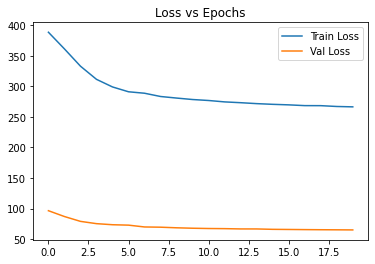

In [12]:
train(model, trainset, batch_size, seq_len, epochs, lr=lr, valid=validset)

### 模型预测

In [13]:
def predict(model, char, top_k = None, hidden_size = None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()
    with torch.no_grad():
        char = np.array([char]) # 转换为array
        char = char.reshape(-1, 1) # shape转换
        char_encoding = model.onehot_encode(char) # encoding
        char_encoding = char_encoding.reshape(1, 1, -1) # (batch_size, seq_len, num_features)
        char_tensor = torch.tensor(char_encoding, dtype=torch.float32) # 类型转换
        char_tensor = char_tensor.to(device) # 部署到device上
        
        out, hidden_size = model(char_tensor, hidden_size) # 模型预测
   
        probs = F.softmax(out, dim=1).squeeze() # torch.Size([1, 83]) --> torch.Size([83])
        #probs = F.softmax(out, dim=1).data # 另一种写法，结果一致
        
        
        if top_k is None:
            indices = np.arange(vocab_size)
        else:
            probs, indices = probs.topk(top_k) # 选取概率最大的前top_k个
            indices = indices.cpu().numpy()
        
        probs = probs.cpu().numpy()
        
        char_index = np.random.choice(indices, p = probs / probs.sum()) # 随机选取一个索引
        char = model.int_char[char_index] # 获取索引对应的字符
        
    return char, hidden_size

In [14]:
# 获取一个样本
def sample(model, length, top_k = None, sentence="every unhappy family "):
    hidden_size = None # 初始化
    new_sentence = [char for char in sentence] # 初始化
    for i in range(length):
        next_char, hidden_size = predict(model, new_sentence[-1], top_k = top_k, hidden_size = hidden_size) # 预测下一个字符
        new_sentence.append(next_char)
        
    return ''.join(new_sentence)

In [15]:
new_text = sample(model, 2000, top_k=5)

In [16]:
new_text

'every unhappy family cheed ale tall.\nAnd he welle as than stitt hou the hart and sooker..".\n\n"Yons the with and ale\nfise ale, and seet ont his a coud. When the wast and wered\nand alraly that sert, evere the shull,\nand see and her the hims to the seest to me the storte the ther hout to ware the cortitsing whout hir\nstour the her the well\nats her, bet te storted has, and whel so te tale thime and the his the stert oft ont. He a cert him," that hent to hid to to maller and\ntoone to the segt the cand that sart to with, at to to wame they was wishting\nhe wamite the tong the come were shey him, and he was soud as to mort the the cowed and the some would. Whing," the he with that her.""\n\n"Ne a come hens a ducling her and ather were, the harken the has of\nthere was the sers ot this thind weringes hered hams, the tooded was. White, whan strerend aly the\npronened her thil ale that to\nwenl, therit and that asding, whing, and seed steid the hert. He the saserter," saste a derederes

### 保存模型

In [17]:
model_name = "lstm_model.net"

checkpoint = {
    'hidden_size' : model.hidden_size,
    'num_layers' : model.num_layers,
    'state_dict' : model.state_dict()
}

with open(model_name, 'wb') as f:
    torch.save(checkpoint, f)